In [127]:
import numpy as np
import pandas as pd
import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler 

In [128]:
# THIS REMOVES ARTICLES WRITTEN ON NON-BUSINESS DAYS

hist_df = pd.read_csv('data/AAPL_2024-06-16.csv')
sent_df = pd.read_csv('data/AAPL_sent.csv')
df = pd.merge(hist_df, sent_df, left_on='timestamp', right_on='date', how='left')
df = df[['timestamp','open','high','low','close','volume','compound']]
df.rename(columns={'compound': 'sentiment'}, inplace=True)
df

,timestamp,open,high,low,close,volume,sentiment
0,1999-11-01,80.00,80.69,77.37,77.62,2487300,NaN
1,1999-11-02,78.00,81.69,77.31,80.25,3564600,NaN
2,1999-11-03,81.62,83.25,81.00,81.50,2932700,NaN
3,1999-11-04,82.06,85.37,80.62,83.62,3384700,NaN
4,1999-11-05,84.62,88.37,84.00,88.31,3721500,NaN
...,...,...,...,...,...,...,...
6190,2024-06-10,196.90,197.30,192.15,193.12,97262077,-0.045220
6191,2024-06-11,193.65,207.16,193.63,207.15,172373296,0.085237
6192,2024-06-12,207.37,220.20,206.90,213.07,198134293,0.131361
6193,2024-06-13,214.74,216.75,211.60,214.24,97862729,0.008962


In [129]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

In [130]:
def split_data(data, training_split, features):
  split_row = int(data.shape[0]*training_split)
  training_set = data[features].iloc[:split_row].values
  testing_set = data[features].iloc[split_row:].values
  return training_set, testing_set


def get_x_y(dataset, window_size, label_feature, feature_count):
  X, y = [], []
  for i in range(window_size, len(dataset)):
    X.append(dataset[i-window_size:i])
    y.append(dataset[i, label_feature])

  X, y = np.array(X), np.array(y)
  X = np.reshape(X, (X.shape[0], window_size, feature_count))
  return X, y

In [131]:
# Replace NaNs with a temporary placeholder for scaling
placeholder_value = -2
# df['sentiment'].fillna(placeholder_value, inplace=True)

# Split data into training and testing
print(type(df))
training_set, testing_set = split_data(df, 0.8, ['open', 'high', 'low', 'close', 'volume', 'sentiment'])
print("training_set: ", training_set.shape)
print("testing_set: ", testing_set.shape)

<class 'pandas.core.frame.DataFrame'>
training_set:  (4956, 6)
testing_set:  (1239, 6)


In [132]:
training_set

array([[8.0000000e+01, 8.0690000e+01, 7.7370000e+01, 7.7620000e+01,
        2.4873000e+06,           nan],
       [7.8000000e+01, 8.1690000e+01, 7.7310000e+01, 8.0250000e+01,
        3.5646000e+06,           nan],
       [8.1620000e+01, 8.3250000e+01, 8.1000000e+01, 8.1500000e+01,
        2.9327000e+06,           nan],
       ...,
       [2.0331000e+02, 2.0439000e+02, 2.0171000e+02, 2.0175000e+02,
        2.0191842e+07, 3.1414000e-01],
       [2.0245000e+02, 2.0400000e+02, 2.0220000e+02, 2.0330000e+02,
        1.7595212e+07, 0.0000000e+00],
       [2.0409000e+02, 2.0587000e+02, 2.0400000e+02, 2.0521000e+02,
        1.6947420e+07,           nan]])

In [133]:
# Example data preparation
scaler = RobustScaler()

training_set = scaler.fit_transform(training_set)
testing_set = scaler.fit_transform(testing_set)

In [134]:
training_set

array([[-0.25484573, -0.2577573 , -0.26697695, -0.27287525, -0.75590068,
                nan],
       [-0.268666  , -0.25088102, -0.26739549, -0.25465817, -0.70804483,
                nan],
       [-0.24365131, -0.24015403, -0.2416552 , -0.24599986, -0.73611511,
                nan],
       ...,
       [ 0.59724286,  0.59283836,  0.60037986,  0.58692942,  0.03057088,
         1.57942274],
       [ 0.59130014,  0.59015661,  0.60379795,  0.59766572, -0.08477668,
        -0.37810708],
       [ 0.60263276,  0.60301525,  0.61635418,  0.61089562, -0.11355291,
                nan]])

In [135]:
nan_mask = np.isnan(training_set)

# Replace NaNs with -2
training_set[nan_mask] = -2

print(training_set)

nan_mask = np.isnan(testing_set)

# Replace NaNs with -2
testing_set[nan_mask] = -2

print(testing_set)

[[-0.25484573 -0.2577573  -0.26697695 -0.27287525 -0.75590068 -2.        ]
 [-0.268666   -0.25088102 -0.26739549 -0.25465817 -0.70804483 -2.        ]
 [-0.24365131 -0.24015403 -0.2416552  -0.24599986 -0.73611511 -2.        ]
 ...
 [ 0.59724286  0.59283836  0.60037986  0.58692942  0.03057088  1.57942274]
 [ 0.59130014  0.59015661  0.60379795  0.59766572 -0.08477668 -0.37810708]
 [ 0.60263276  0.60301525  0.61635418  0.61089562 -0.11355291 -2.        ]]
[[ 0.69960104  0.71658078  0.71120369  0.71461531 -1.16698027 -0.87928648]
 [ 0.68896222  0.69596848  0.70664088  0.69154379 -1.23249791 -3.53303603]
 [ 0.68797715  0.71193291  0.71517135  0.73788745 -1.12625158  0.86308883]
 ...
 [ 0.75437128  1.00131353  0.77865397  0.8865483   3.13698565  0.48247074]
 [ 0.89957149  0.93159543  0.87189406  0.91002107  0.75616477 -0.39588139]
 [ 0.88203714  0.89966657  0.86594257  0.87491223  0.09751417 -0.90861312]]


In [136]:
X_train, y_train = get_x_y(training_set, 14, 3, 6)
val_split_row = int(X_train.shape[0]*0.8) # 20% will be used for validation
X_train, X_val = X_train[:val_split_row], X_train[val_split_row:]
y_train, y_val = y_train[:val_split_row], y_train[val_split_row:]
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)

X_train:  (3953, 14, 6)
y_train:  (3953,)
X_val:  (989, 14, 6)
y_val:  (989,)


In [137]:
# seq_length = 60  # Example sequence length
# sequences = create_sequences(data, seq_length)

In [138]:
# # Creating mask for missing sentiment values
# sentiment_column_index = 5
# mask = np.isnan(sequences[:, :, sentiment_column_index])

# # Replacing NaNs with a placeholder (e.g., -2) that will be masked out
# sequences[:, :, sentiment_column_index] = np.nan_to_num(sequences[:, :, sentiment_column_index], nan=-2)

# X = sequences[:, :-1, :]
# y = sequences[:, -1, 3]  # Example: predicting the 'close' price

In [139]:
# split = int(0.8 * len(X))
# X_train, X_test = X[:split], X[split:]
# y_train, y_test = y[:split], y[split:]
# mask_train, mask_test = mask[:split, :-1], mask[split:, :-1]

In [140]:
# placeholder_value = -2
# X_train[:, :, 5][np.isnan(X_train[:, :, 5])] = placeholder_value
# X_test[:, :, 5][np.isnan(X_test[:, :, 5])] = placeholder_value

# # Create mask arrays: True where sentiment is placeholder_value, False otherwise
# mask_train = (X_train[:, :, 5] == placeholder_value)
# mask_test = (X_test[:, :, 5] == placeholder_value)

In [141]:
# # Custom loss function to ignore masked values
# def custom_loss(y_true, y_pred):
#     mask = tf.cast(tf.not_equal(y_true, -2), dtype=tf.float32)
#     loss = tf.reduce_sum(mask * tf.square(y_true - y_pred)) / tf.reduce_sum(mask)
#     return loss

def build_model(window_size, feature_count):
    d = 0.1
    model = Sequential()
    model.add(Masking(mask_value=placeholder_value, input_shape=(window_size, feature_count)))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(d))
    model.add(BatchNormalization())  # Adding batch normalization

    model.add(LSTM(64, return_sequences=True))  # Adding another LSTM layer with more units
    model.add(Dropout(d))
    model.add(BatchNormalization())  # Adding batch normalization

    # model.add(LSTM(32, return_sequences=True))  # Adding another LSTM layer
    # model.add(Dropout(d))
    # model.add(BatchNormalization())  # Adding batch normalization

    model.add(LSTM(32))  # Final LSTM layer without return_sequences
    model.add(Dropout(d))
    model.add(BatchNormalization())  # Adding batch normalization

    model.add(Dense(64, activation="relu", kernel_initializer="he_uniform"))  # Increased units and changed initializer
    model.add(Dropout(d))  # Adding dropout after Dense layer

    model.add(Dense(32, activation="relu", kernel_initializer="he_uniform"))  # Adding another Dense layer
    model.add(Dropout(d))  # Adding dropout after Dense layer

    model.add(Dense(16, activation="relu", kernel_initializer="he_uniform"))  # Original Dense layer
    model.add(Dropout(d))  # Adding dropout after Dense layer

    model.add(Dense(1, activation="linear", kernel_initializer="he_uniform"))  # Output layer with linear activation

    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    # model = Sequential()
    # model.add(Masking(mask_value=placeholder_value, input_shape=(window_size, feature_count)))
    # model.add(LSTM(128, input_shape=(window_size, feature_count), return_sequences=True))
    # model.add(LSTM(32))
    # model.add(Dropout(d))
    # model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
    # model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
    # model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    # model.compile(optimizer='adam', loss=custom_loss)
    return model

In [142]:
window_size = 60  # Example window size
feature_count = 6  # Number of features (e.g., open, high, low, close, volume, sentiment)
model = build_model(window_size, feature_count)
model.summary()

c:\Users\blkeu\anaconda3\envs\CS172B311\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_6 (Masking)             │ (None, 60, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 60, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 60, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 60, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,577 (533.50 KB)

 Trainable params: 136,129 (531.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [143]:
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2)

Epoch 1/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.5517 - mae: 0.5154 - val_loss: 3.5430 - val_mae: 1.5005
Epoch 2/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1743 - mae: 0.2911 - val_loss: 2.3924 - val_mae: 1.2444
Epoch 3/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1268 - mae: 0.2378 - val_loss: 1.3079 - val_mae: 0.9793
Epoch 4/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1101 - mae: 0.2344 - val_loss: 0.8855 - val_mae: 0.7919
Epoch 5/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0999 - mae: 0.2198 - val_loss: 0.8265 - val_mae: 0.5728
Epoch 6/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1013 - mae: 0.2086 - val_loss: 1.2297 - val_mae: 0.7793
Epoch 7/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0820 - mae: 0.1940 - val_loss: 0.6425 - val_mae: 0.5660
Epoch 8/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0813 - mae: 0.1892 - val_loss: 0.7640 - val_mae: 0.7247
Epoch 9/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.088

In [144]:
# Scale test set
scaler = MinMaxScaler()
testing_set = scaler.fit_transform(testing_set)

# Get X and y from testing set
X_test, y_test = get_x_y(testing_set, 14, 4, 6)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

X_test:  (1225, 14, 6)
y_test:  (1225,)
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7545 - mae: 2.1750
Test Loss: [4.587826728820801, 2.1376962661743164]


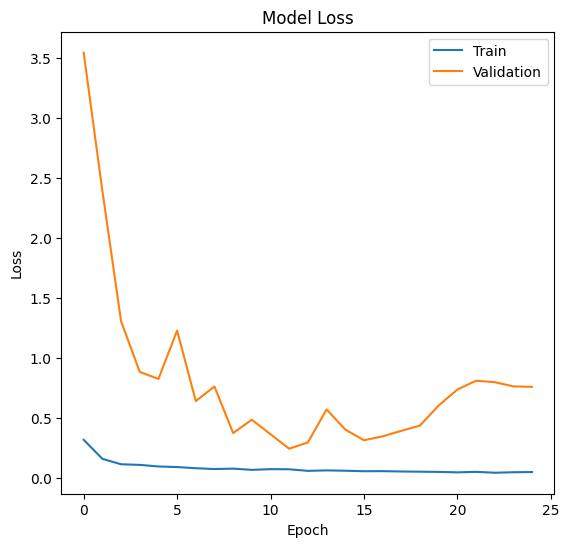

In [145]:
# Plot training & validation loss values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


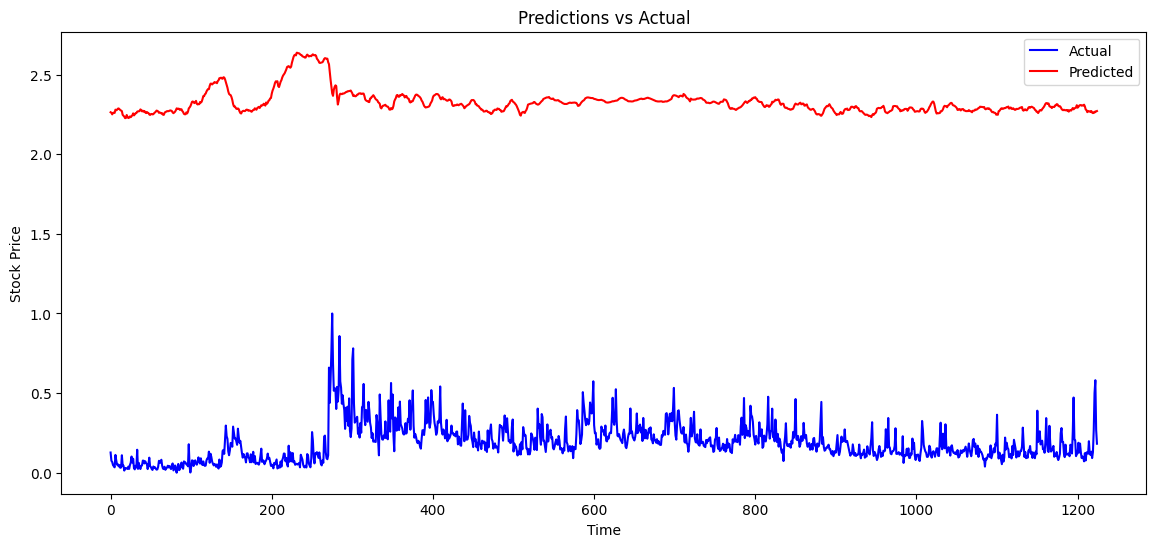

In [146]:
# Generate predictions
y_pred = model.predict(X_test)

# Plot predictions vs actual results
plt.figure(figsize=(14, 6))
plt.plot(y_test, color='blue', label='Actual')
plt.plot(y_pred, color='red', label='Predicted')
plt.title('Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(['Actual', 'Predicted'], loc='upper right')
plt.show()

In [147]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7545 - mae: 2.1750
test loss, test acc: [4.587826728820801, 2.1376962661743164]
